# Zadanie 8 (02.02.2025)
Wykorzystać zbiór danych opracowywany na zajęciach i stworzyć ramkę danych zawierającą klasę (fake/true news) oraz liczbę znaków, słów, unikalnych słów, zdań, wartości TTR or C, jak również indeks FOG, a następnie zbudować klasyfikator (dowolny) i sprawdzić jego skuteczność (metodą kroswalidacji). Dla chętnych: wykonać PCA na takim zbiorze danych i przedstawić wnioski z takiej analizy.

In [22]:
import pandas as pd

data = pd.read_csv("http://jsienkiewicz.pl/TEXT/lab/data_fn.csv")

data["text"] = data.text.apply(str)
data["label"] = data["label"].apply(str)

data.text.apply(lambda x: x.replace("\n", ""))
display(data.head())

,Unnamed: 0,id,title,author,text,label
0,952,951,[WATCH] Thug Calls US Marine a “Pussy” – Barel...,The Conservative Millennial,0 comments \nA video uploaded in 2013 called “...,1
1,11483,11482,Trump Says Health Law Replacement May Not Be R...,Mark Landler,"WEST PALM BEACH, Fla. — President Trump sai...",0
2,18965,18964,Downside of Being a Global Hub: Invasive Speci...,Sarah Maslin Nir,"Some are disarmingly named, like the cutesy Ch...",0
3,6812,6811,"American Tourist Can’t Get Over Dirty, Decayin...",Julius Hubris,0 Add Comment \nA VISITING American tourist ha...,1
4,11026,11025,Damascus Bombings Near Pilgrimage Sites Kill D...,Ben Hubbard,"BEIRUT, Lebanon — A double bombing near Shi...",0


In [23]:
import numpy as np
import pandas as pd
from readability.readability import Readability
from lexicalrichness import LexicalRichness

# Step 1: Readability statistics
r = [Readability(text) for text in data.text]

def read_stats(r):
    try:
        return r.statistics()
    except:
        return {
            'num_letters': None,
            'num_words': None,
            'num_sentences': None,
            'num_polysyllabic_words': None,
            'avg_words_per_sentence': None,
            'avg_syllables_per_word': None
        }

df_read_stats = pd.DataFrame.from_dict([read_stats(x) for x in r])
df_read_stats.drop(columns=['num_words', 'num_polysyllabic_words', 'avg_words_per_sentence', 'avg_syllables_per_word'], axis=1, inplace=True)

# Step 2: Lexical richness statistics (updated to include additional metrics)
lr = [LexicalRichness(text) for text in data.text]

def make_richness_stats(l):
    total_words = l.words
    unique_words = len(set(l.wordlist))
    TTR = l.ttr if l.terms > 1 else None
    Herdan = l.Herdan if l.terms > 1 else None
    return [total_words, unique_words, TTR, Herdan]

rich = [make_richness_stats(l) for l in lr]

df_rich_stats = pd.DataFrame(rich)
df_rich_stats.columns = ["num_words", "unique_words", "TTR", "Herdan"]

# Step 3: Combine readability stats and lexical richness
features = pd.concat([df_read_stats, df_rich_stats], axis=1)
features["news"] = np.where(data.label == "1", "fake", "true")
features.dropna(inplace=True)

features

,num_letters,num_sentences,num_words,unique_words,TTR,Herdan,news
0,336.0,5.0,71,61,0.859155,0.964387,fake
1,2038.0,14.0,424,227,0.535377,0.896725,true
2,5971.0,54.0,1235,557,0.451012,0.888147,true
3,1453.0,10.0,315,191,0.606349,0.913030,fake
4,2497.0,22.0,520,268,0.515385,0.894010,true
...,...,...,...,...,...,...,...
1995,2450.0,17.0,472,238,0.504237,0.888792,fake
1996,460.0,5.0,102,80,0.784314,0.947471,fake
1997,2499.0,14.0,470,264,0.561702,0.906256,true
1998,15774.0,114.0,3185,1278,0.401256,0.886792,fake


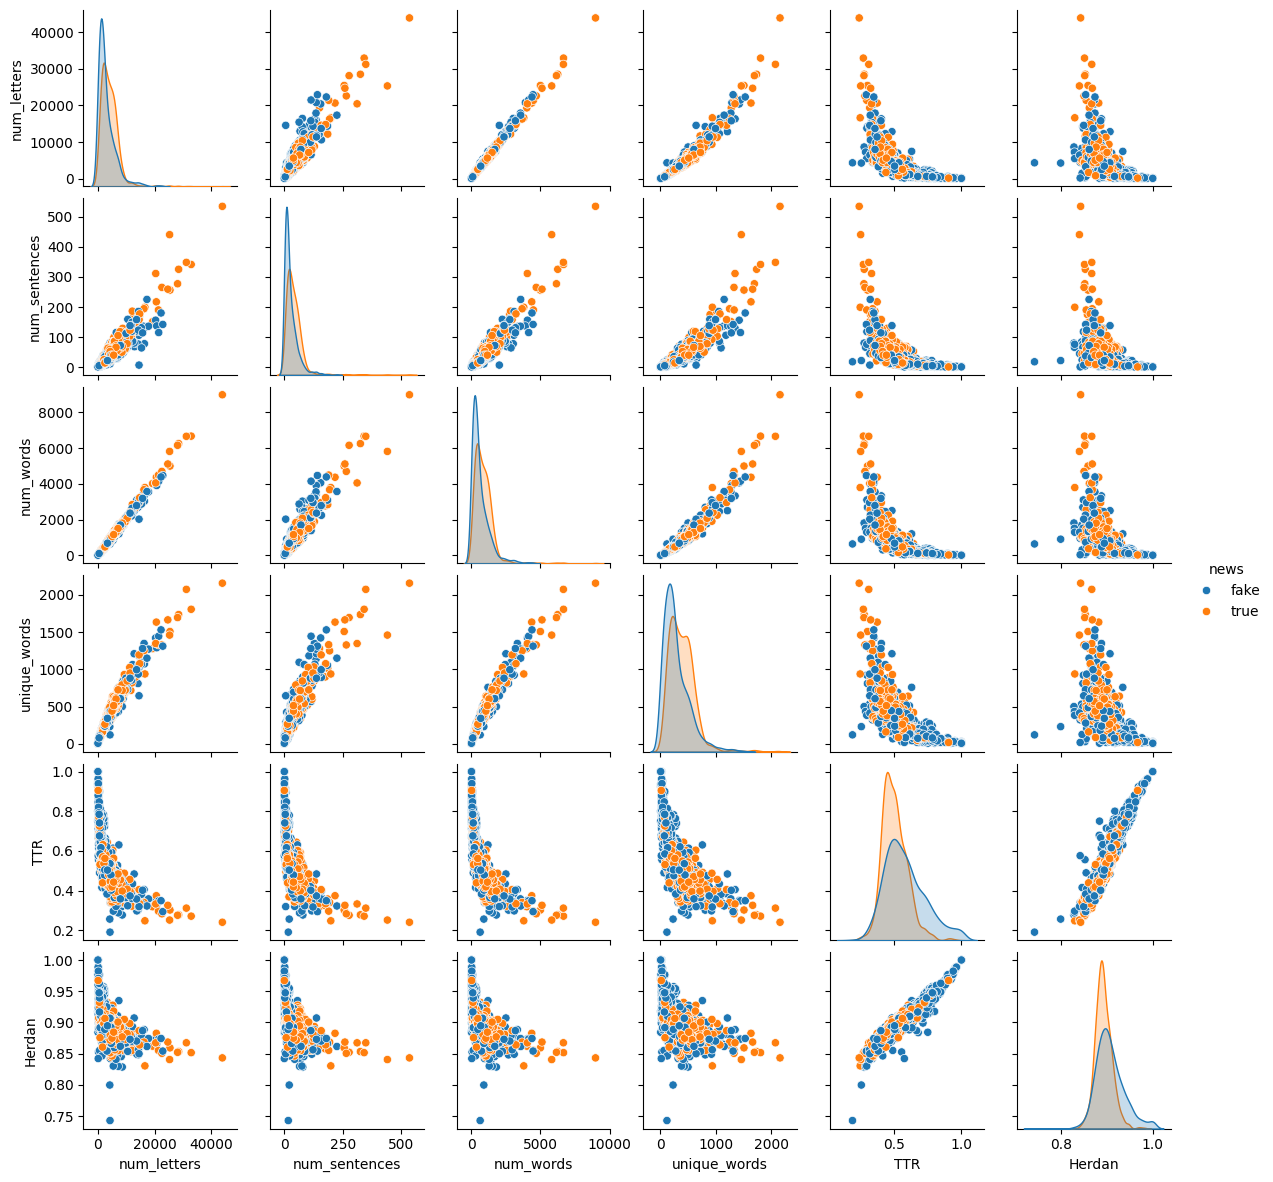

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.pairplot(features, hue='news', height=2)


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


# Step 1: Prepare the data
# `features` contains the feature DataFrame, and `data['label']` is the target column
X = features.drop(columns=['news'])  # Features
y = features['news']  # Labels

# Standardize the data (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation standard deviation: {cv_scores.std():.4f}")

# Step 3: Train on full data and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Cross-validation accuracy: 0.6604
Cross-validation standard deviation: 0.0222

Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.54      0.60       189
        true       0.65      0.76      0.70       208

    accuracy                           0.66       397
   macro avg       0.66      0.65      0.65       397
weighted avg       0.66      0.66      0.66       397

Test Accuracy: 0.6599


Explained variance by the first two components: [0.81470488 0.15866633 0.0175437 ]


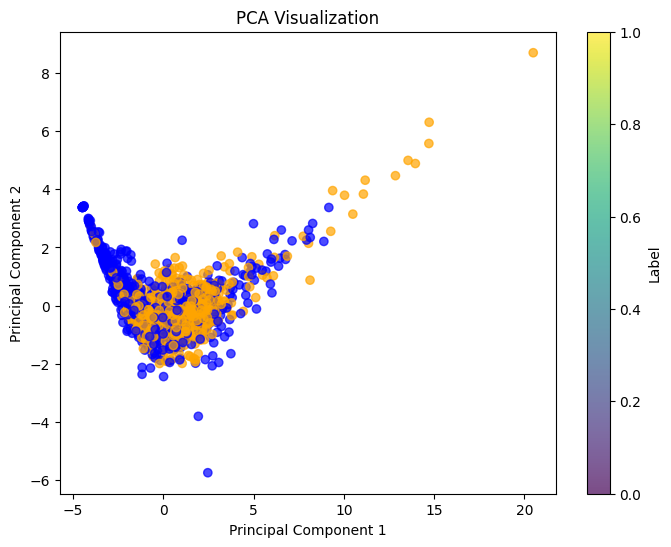

In [26]:
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance by the first two components: {pca.explained_variance_ratio_}")

# Visualize PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=['blue' if i == 'fake' else 'orange' for i in y], alpha=0.7)
plt.colorbar(label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()